# Financial Market Analytics Dashboard

This notebook implements a mini Bloomberg-style market analytics dashboard.

**Goals:**
- Use real financial market data from Yahoo Finance (`yfinance`)
- Compute and visualize common technical indicators (SMA/EMA, RSI, MACD, Bollinger Bands, volatility, volume)
- Compare indices, sectors, and stocks
- Explain market behavior in a way that is understandable for non-technical / non-finance audiences

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

pd.set_option("display.max_columns", 50)
plt.style.use("seaborn-v0_8")

print("Libraries loaded.")

Libraries loaded.


## 1. Define Market Universe & Date Range

In this section we define:
- Major indices (S&P 500, NASDAQ 100, Russell 2000)
- Sector ETFs (Tech, Financials, Energy)
- Large-cap individual stocks

We also set the date range for our analysis.

In [2]:
# Indices, sectors, and single-name stocks
index_tickers = ["SPY", "QQQ", "IWM"]           # S&P 500, Nasdaq 100, Russell 2000
sector_tickers = ["XLK", "XLF", "XLE"]          # Tech, Financials, Energy
single_tickers = ["AAPL", "MSFT", "NVDA", "AMZN"]

TICKERS = index_tickers + sector_tickers + single_tickers

start_date = "2020-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

TICKERS, start_date, end_date

(['SPY', 'QQQ', 'IWM', 'XLK', 'XLF', 'XLE', 'AAPL', 'MSFT', 'NVDA', 'AMZN'],
 '2020-01-01',
 '2025-11-15')

## 2. Download Market Data (Yahoo Finance)

We use `yfinance` to download historical OHLCV data for all tickers:

- Open, High, Low, Close, Adjusted Close
- Volume

This will be the foundation for all of our analysis and indicators.

In [3]:
data_raw = yf.download(
    TICKERS,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    group_by="ticker",
    progress=True
)

data_raw.head()

[*********************100%***********************]  10 of 10 completed


Ticker            MSFT                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2020-01-02  158.779999  160.729996  158.330002  160.619995  152.791092   
2020-01-03  158.320007  159.949997  158.059998  158.619995  150.888596   
2020-01-06  157.080002  159.100006  156.509995  159.029999  151.278625   
2020-01-07  159.320007  159.669998  157.320007  157.580002  149.899323   
2020-01-08  158.929993  160.800003  157.949997  160.089996  152.286957   

Ticker                     AMZN                                              \
Price         Volume       Open       High        Low      Close  Adj Close   
Date                                                                          
2020-01-02  22622100  93.750000  94.900497  93.207497  94.900497  94.900497   
2020-01-03  21116200  93.224998  94.309998  93.224998  93.748497  93.748497   
2020-01-06  20813700  93.000000  95.184502  93.000000  95.143997  95.143997   
2020-01-07  21634100  95.224998  95.694504  94.601997  95.343002  95.343002   
2020-01-08  27746500  94.902000  95.550003  94.321999  94.598503  94.598503   

Ticker                       IWM                                      \
Price         Volume        Open        High         Low       Close   
Date                                                                   
2020-01-02  80580000  166.740005  166.750000  164.229996  165.779999   
2020-01-03  75288000  163.740005  165.410004  163.699997  165.130005   
2020-01-06  81236000  163.850006  165.539993  163.539993  165.350006   
2020-01-07  80898000  164.850006  165.339996  164.210007  164.800003   
2020-01-08  70160000  164.820007  166.029999  164.720001  165.309998   

Ticker                                  XLK                                   \
Price        Adj Close    Volume       Open       High        Low      Close   
Date                                                                           
2020-01-02  154.221481  18297500  92.500000  93.389999  92.320000  93.389999   
2020-01-03  153.616760  19295600  92.029999  92.980003  92.019997  92.339996   
2020-01-06  153.821426  17150900  91.419998  92.660004  91.250000  92.559998   
2020-01-07  153.309799  11817900  92.720001  92.980003  92.379997  92.519997   
2020-01-08  153.784241  13832400  92.620003  93.919998  92.449997  93.510002   

Ticker                                  QQQ  ...       XLF         SPY  \
Price       Adj Close    Volume        Open  ...    Volume        Open   
Date                                         ...                         
2020-01-02  88.833031  13283500  214.399994  ...  28843300  323.540009   
2020-01-03  87.834267  15011800  213.300003  ...  51363600  321.160004   
2020-01-06  88.043549   7815000  212.500000  ...  27956100  320.489990   
2020-01-07  88.005493   7681800  215.639999  ...  39627500  323.019989   
2020-01-08  88.947212  11627200  215.500000  ...  47966600  322.940002   

Ticker                                                                   NVDA  \
Price             High         Low       Close   Adj Close    Volume     Open   
Date                                                                            
2020-01-02  324.890015  322.529999  324.869995  298.578613  59151200  5.96875   
2020-01-03  323.640015  321.100006  322.410004  296.317780  77709700  5.87750   
2020-01-06  323.730011  320.359985  323.640015  297.448212  55653900  5.80800   
2020-01-07  323.540009  322.239990  322.730011  296.611847  40496400  5.95500   
2020-01-08  325.779999  322.670013  324.450012  298.192627  68296000  5.99400   

Ticker                                                           AAPL  \
Price          High      Low    Close Adj Close     Volume       Open   
Date                                                                    
2020-01-02  5.99775  5.91800  5.99775  5.971411  237536000  74.059998   
2020-01-03  5.94575  5

## 3. Clean Data & Extract Adjusted Close

For most price-based indicators, we focus on **Adjusted Close** prices.
We reshape the data into a clean `DataFrame` where each column is a ticker.

In [4]:
# Extract Adjusted Close for each ticker
adj_close = pd.concat(
    {ticker: data_raw[ticker]["Adj Close"] for ticker in TICKERS},
    axis=1
)
adj_close.columns.name = "Ticker"

# Extract Volume for each ticker
volume = pd.concat(
    {ticker: data_raw[ticker]["Volume"] for ticker in TICKERS},
    axis=1
)
volume.columns.name = "Ticker"

adj_close.tail()


Ticker,SPY,QQQ,IWM,XLK,XLF,XLE,AAPL,MSFT,NVDA,AMZN
Date,,,,,,,,,,
2025-11-10,681.440002,623.229980,244.029999,295.529999,52.970001,90.349998,269.429993,506.000000,199.050003,248.399994
2025-11-11,683.000000,621.570007,244.240005,293.010010,53.209999,91.529999,275.250000,508.679993,193.160004,249.100006
2025-11-12,683.380005,621.080017,243.639999,293.920013,53.669998,90.250000,273.470001,511.140015,193.800003,244.199997
2025-11-13,672.039978,608.400024,236.789993,286.589996,52.980000,90.480003,272.950012,503.290009,186.860001,237.580002
2025-11-14,671.929993,608.859985,237.479996,288.149994,52.450001,92.019997,272.410004,510.179993,190.169998,234.690002


## 4. Visualize Index Price Movement

To explain the market to a non-technical audience, we start by showing
how the **major indices** move over time.

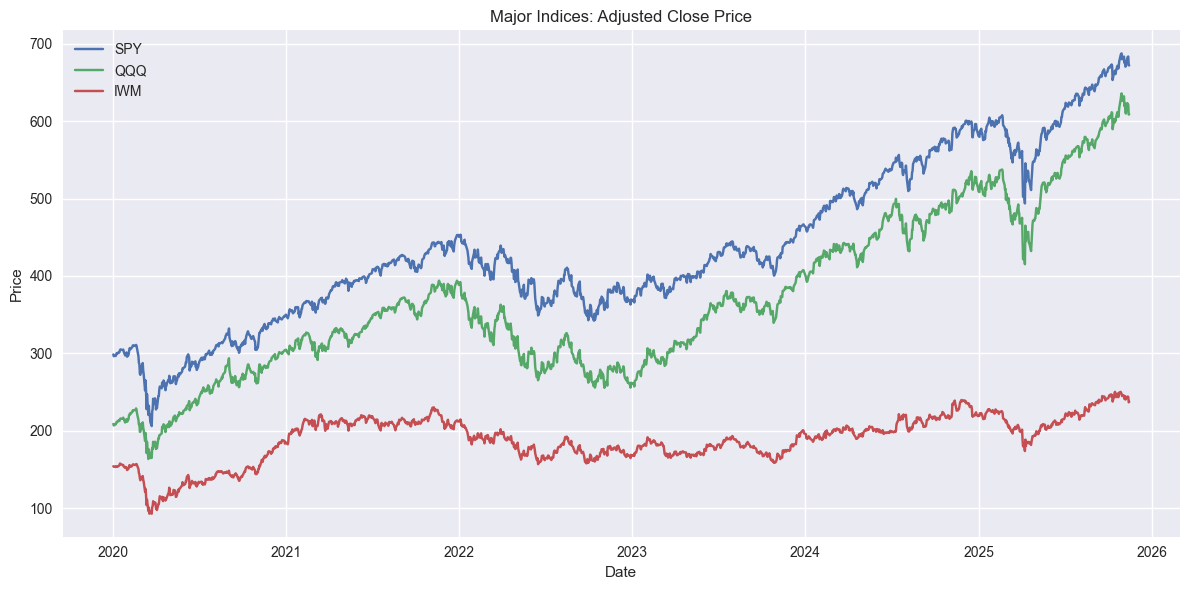

In [5]:
plt.figure(figsize=(12, 6))
for t in index_tickers:
    plt.plot(adj_close.index, adj_close[t], label=t)

plt.title("Major Indices: Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Compute Daily Returns & Basic Statistics

Daily percentage returns help us:
- Compare performance across assets
- Prepare inputs for volatility and risk analysis

In [6]:
returns = adj_close.pct_change().dropna()
print("Shape of returns:", returns.shape)

returns.describe().T.sort_values("std", ascending=False).head(10)

Shape of returns: (1476, 10)


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
NVDA,1476.0,0.002912,0.033729,-0.184521,-0.015680,0.003250,0.022030,0.243696
AMZN,1476.0,0.000869,0.022629,-0.140494,-0.011180,0.000774,0.012956,0.135359
XLE,1476.0,0.000694,0.022036,-0.201412,-0.009497,0.001262,0.010995,0.160373
AAPL,1476.0,0.001101,0.020208,-0.128647,-0.008270,0.001140,0.011587,0.153288
MSFT,1476.0,0.000992,0.018725,-0.147390,-0.007890,0.001110,0.010494,0.142168
XLK,1476.0,0.000953,0.017659,-0.138140,-0.008012,0.001549,0.010170,0.134257
IWM,1476.0,0.000436,0.016887,-0.132669,-0.008808,0.000680,0.010257,0.091491
XLF,1476.0,0.000557,0.016058,-0.137093,-0.006323,0.000828,0.007959,0.131566
QQQ,1476.0,0.000854,0.016046,-0.119788,-0.006733,0.001414,0.009323,0.120031


## 6. Technical Indicator Functions

We now define helper functions to compute:

- SMA / EMA (trend)
- RSI (momentum)
- MACD (trend + momentum)
- Bollinger Bands (volatility + price patterns)
- ATR & Rolling Std Dev (volatility)


In [7]:
def sma(series: pd.Series, window: int = 20) -> pd.Series:
    return series.rolling(window).mean()


def ema(series: pd.Series, window: int = 20) -> pd.Series:
    return series.ewm(span=window, adjust=False).mean()


def rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=series.index)
    loss = pd.Series(loss, index=series.index)

    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()

    rs = avg_gain / avg_loss
    rsi_val = 100 - (100 / (1 + rs))
    return rsi_val


def macd(series: pd.Series,
         fast: int = 12,
         slow: int = 26,
         signal: int = 9) -> pd.DataFrame:
    ema_fast = ema(series, fast)
    ema_slow = ema(series, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line

    return pd.DataFrame(
        {"MACD": macd_line, "Signal": signal_line, "Hist": hist},
        index=series.index
    )


def bollinger_bands(series: pd.Series,
                    window: int = 20,
                    num_std: float = 2.0) -> pd.DataFrame:
    sma_mid = sma(series, window)
    rolling_std = series.rolling(window).std()
    upper = sma_mid + num_std * rolling_std
    lower = sma_mid - num_std * rolling_std

    return pd.DataFrame(
        {"Middle": sma_mid, "Upper": upper, "Lower": lower},
        index=series.index
    )


def atr(high: pd.Series,
        low: pd.Series,
        close: pd.Series,
        window: int = 14) -> pd.Series:
    high_low = high - low
    high_close = (high - close.shift()).abs()
    low_close = (low - close.shift()).abs()

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr_val = tr.rolling(window).mean()
    return atr_val


## 7. Example Indicator for a Single Stock (AAPL)

To demonstrate how indicators work, we compute and plot them for one ticker.
This is useful when explaining market concepts to beginners.



In [8]:
ticker = "AAPL"
price = adj_close[ticker]

# Trend indicators
sma_20 = sma(price, 20)
sma_50 = sma(price, 50)
ema_20 = ema(price, 20)

# Momentum
rsi_14 = rsi(price, 14)
macd_df = macd(price)

# Bollinger Bands
bb_df = bollinger_bands(price, 20, 2)

# ATR (needs high/low/close from raw data)
high = data_raw[ticker]["High"]
low = data_raw[ticker]["Low"]
close = data_raw[ticker]["Close"]
atr_14 = atr(high, low, close, 14)

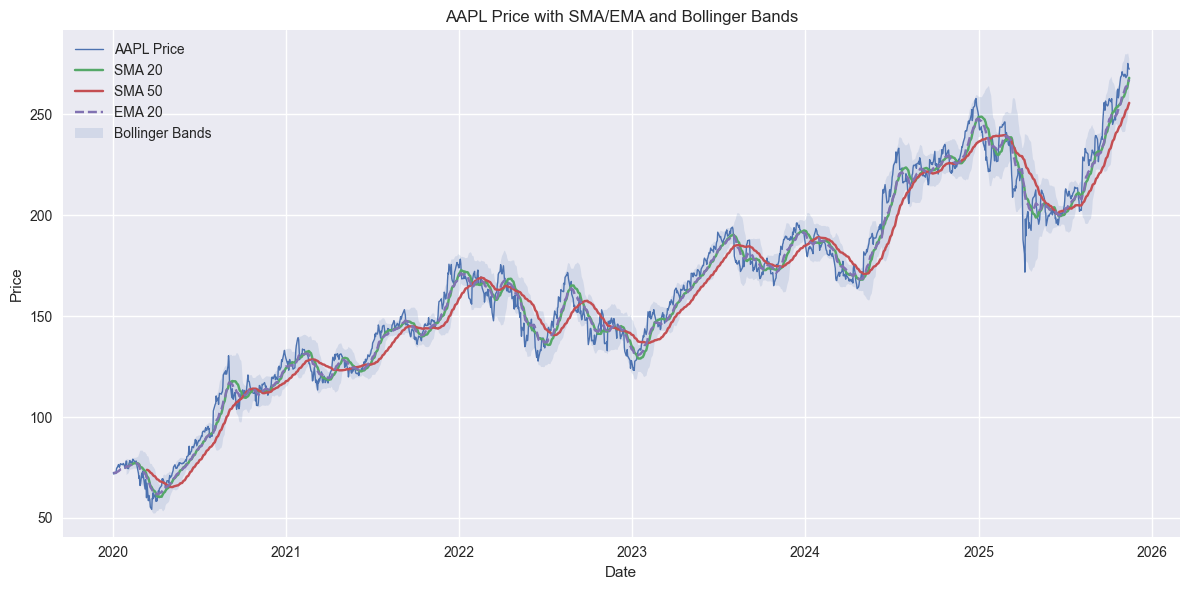

In [9]:
# Plot Price + SMA/EMA + Bollinger
plt.figure(figsize=(12, 6))
plt.plot(price.index, price, label=f"{ticker} Price", linewidth=1)
plt.plot(sma_20.index, sma_20, label="SMA 20")
plt.plot(sma_50.index, sma_50, label="SMA 50")
plt.plot(ema_20.index, ema_20, label="EMA 20", linestyle="--")

plt.fill_between(bb_df.index, bb_df["Upper"], bb_df["Lower"],
                 alpha=0.15, label="Bollinger Bands")

plt.title(f"{ticker} Price with SMA/EMA and Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

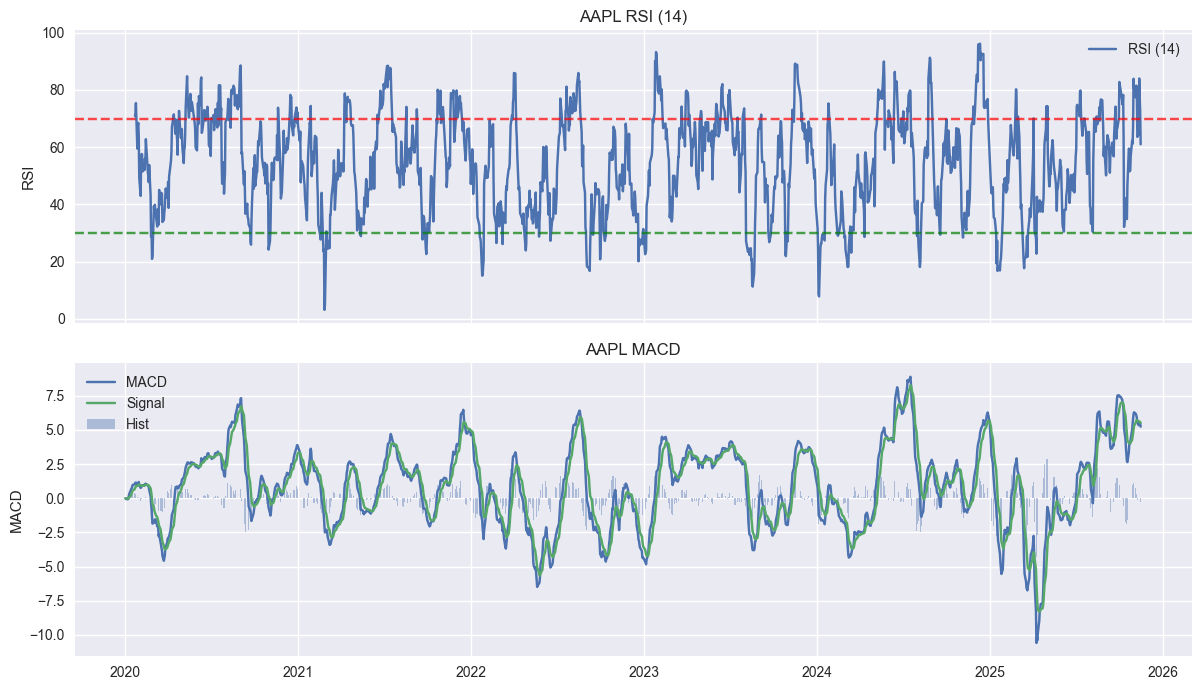

In [10]:
# Plot RSI & MCAD
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# RSI
axes[0].plot(rsi_14.index, rsi_14, label="RSI (14)")
axes[0].axhline(70, linestyle="--", color="red", alpha=0.7)
axes[0].axhline(30, linestyle="--", color="green", alpha=0.7)
axes[0].set_ylabel("RSI")
axes[0].set_title(f"{ticker} RSI (14)")
axes[0].legend()

# MACD
axes[1].plot(macd_df.index, macd_df["MACD"], label="MACD")
axes[1].plot(macd_df.index, macd_df["Signal"], label="Signal")
axes[1].bar(macd_df.index, macd_df["Hist"], label="Hist", alpha=0.4)
axes[1].set_ylabel("MACD")
axes[1].set_title(f"{ticker} MACD")
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Volatility Analysis (Rolling Std Dev & ATR)

Here we look at **volatility**, which helps explain:

- How risky a stock is
- How “calm” or “wild” the market has been


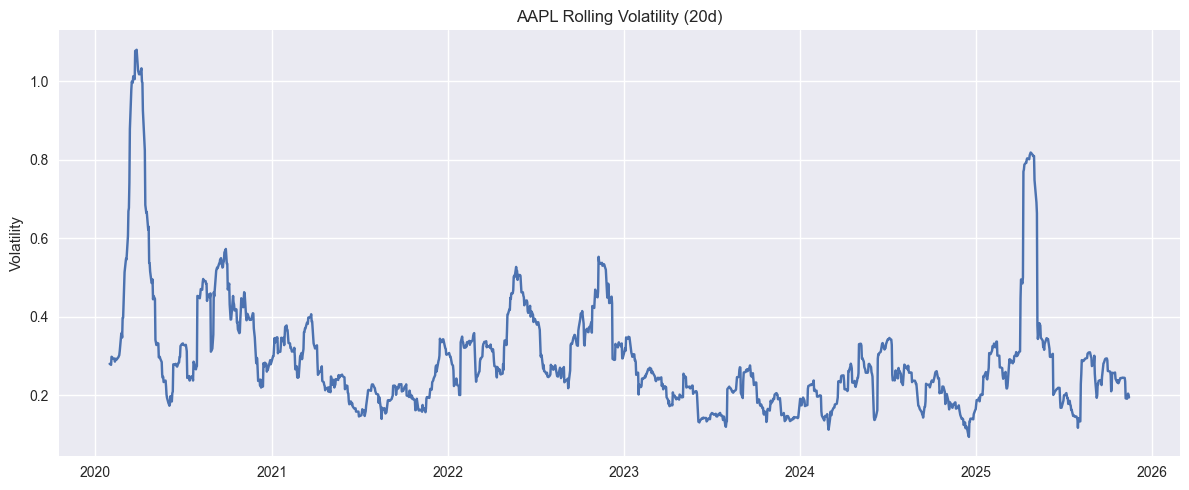

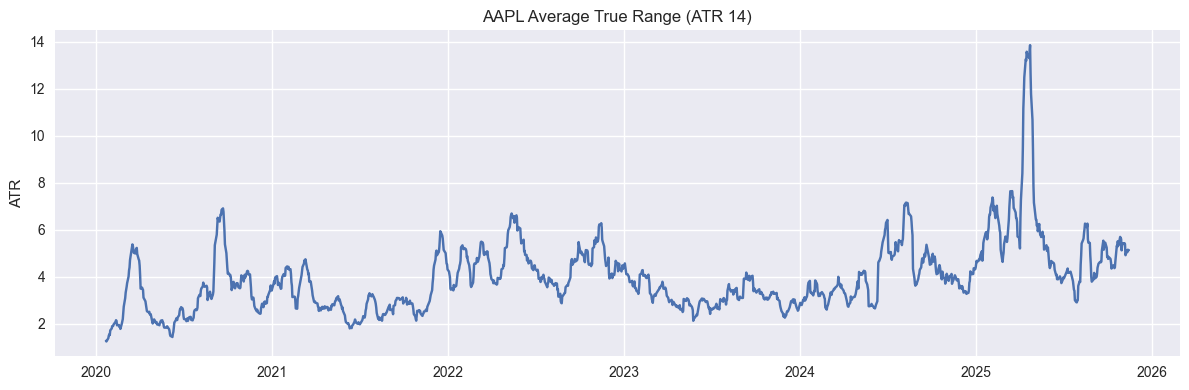

In [11]:
# Rolling 20-day standard deviation of returns (annualized)
rolling_vol_20 = returns[ticker].rolling(20).std() * np.sqrt(252)

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(rolling_vol_20.index, rolling_vol_20, label="Rolling Vol (20d, annualized)")
ax1.set_ylabel("Volatility")
ax1.set_title(f"{ticker} Rolling Volatility (20d)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(atr_14.index, atr_14, label="ATR (14)")
plt.title(f"{ticker} Average True Range (ATR 14)")
plt.ylabel("ATR")
plt.tight_layout()
plt.show()

## 9. Sector & Index Comparison

To help a non-technical audience understand **relative performance**, we compare:

- Major indices (SPY, QQQ, IWM)
- Sector ETFs (XLK, XLF, XLE)

We look at returns over a recent window (e.g., last 60 trading days).

In [12]:
window_days = 60  # ~3 months
recent_prices = adj_close.iloc[-window_days:]

perf_60d = recent_prices.iloc[-1] / recent_prices.iloc[0] - 1
perf_60d = perf_60d.sort_values(ascending=False)

perf_60d.to_frame(name=f"{window_days}D Return").style.format("{:.2%}")

,60D Return
Ticker,
AAPL,19.72%
XLK,9.95%
NVDA,6.85%
QQQ,6.57%
XLE,5.29%
SPY,4.41%
AMZN,2.56%
IWM,1.42%
MSFT,0.58%


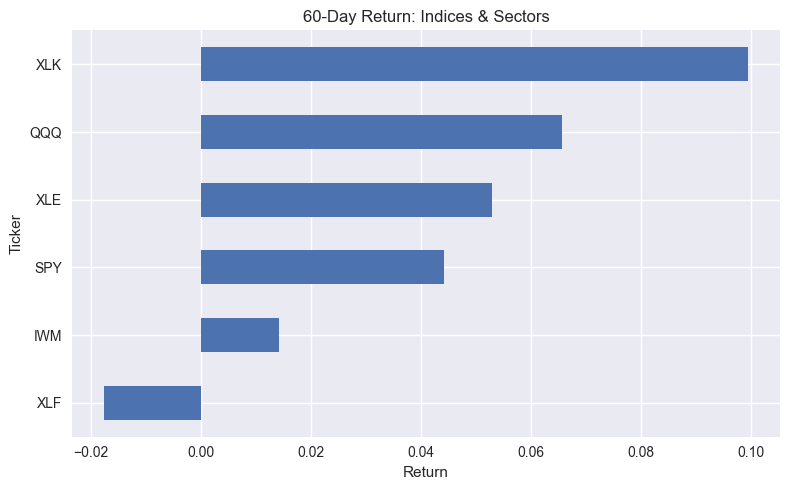

In [13]:
#Bar Plot - Indices & Sector
focus = index_tickers + sector_tickers
focus_perf = perf_60d[focus]

plt.figure(figsize=(8, 5))
focus_perf.sort_values().plot(kind="barh")
plt.title(f"{window_days}-Day Return: Indices & Sectors")
plt.xlabel("Return")
plt.tight_layout()
plt.show()

## 10. Correlation & Diversification

Next, we compute a **correlation matrix** of daily returns to show:

- Which assets move together
- Which assets provide diversification

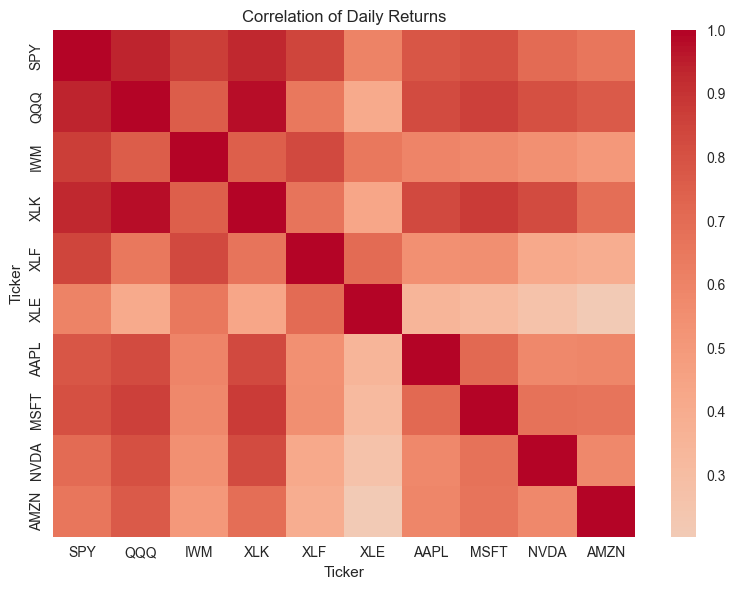

In [14]:
corr = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation of Daily Returns")
plt.tight_layout()
plt.show()


## 11. Simple Trend Signal (Educational Example)

To help beginners understand how indicators can be used in **basic forecasting**,
we build a simple example signal:

- If the 20-day SMA is above the 50-day SMA → "Uptrend"
- If the 20-day SMA is below the 50-day SMA → "Downtrend"

This is not a trading recommendation, but a teaching tool.

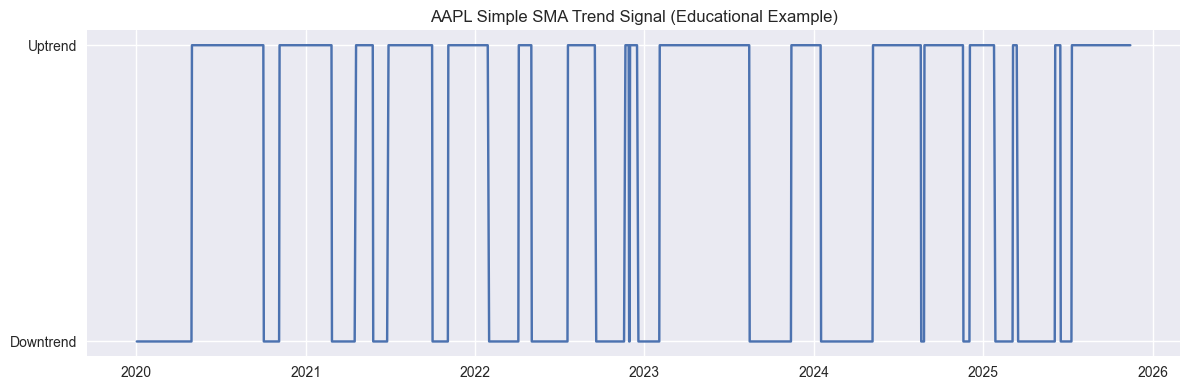

In [15]:
def trend_signal(price_series: pd.Series,
                 short_window: int = 20,
                 long_window: int = 50) -> pd.Series:
    s_short = sma(price_series, short_window)
    s_long = sma(price_series, long_window)
    signal = np.where(s_short > s_long, 1, -1)  # 1 = uptrend, -1 = downtrend
    return pd.Series(signal, index=price_series.index)

signal_aapl = trend_signal(adj_close["AAPL"])

plt.figure(figsize=(12, 4))
plt.plot(signal_aapl.index, signal_aapl, label="Trend Signal")
plt.yticks([-1, 1], ["Downtrend", "Uptrend"])
plt.title("AAPL Simple SMA Trend Signal (Educational Example)")
plt.tight_layout()
plt.show()

## 12. Summary

In this notebook we:

- Pulled real market data from Yahoo Finance
- Computed core technical indicators (SMA/EMA, RSI, MACD, Bollinger Bands, ATR, volatility)
- Compared indices, sectors, and large-cap stocks
- Visualized risk, correlation, and relative performance
- Built a simple educational "trend signal" example

This framework can be extended with:
- Portfolio optimization and risk metrics (Sharpe, max drawdown)
- Event studies (earnings, CPI, FOMC)
- More advanced forecasting models (ARIMA, Prophet, LSTM)

The main purpose is to **explain financial markets to non-technical audiences** using clear visuals and intuitive analytics.